# Left-to-right cheap neurodream

Similar to the 1D automaton (aka "line-to-line automaton"), but this time working with a slightly wider strip of lines. Still kinda recurrent in spirit.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
import tensorflow as tf
import itertools

In [3]:
print(tf.__version__)

2.1.0


In [7]:
# Test if acceleration works
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True) # To force reporting of CPU/GPU placement for individual operations

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


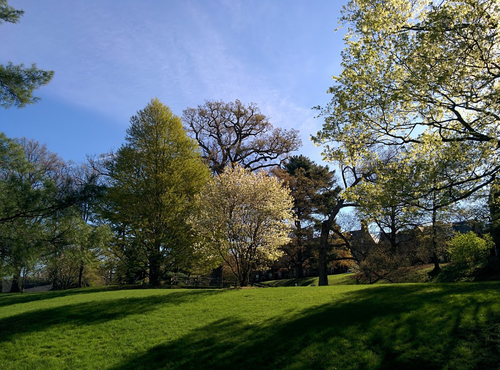

In [8]:
# Read and transform some image
def load_image(i=0, targetSize=(100,200)):
    '''Load i-th image from the input folder.
    
    targetSize: will be downsampled to this (y,x). The smallest of dimensions defines the output size.
    '''
    inFolder = '../pics-in/'
    fileList = os.listdir(inFolder)
    fileName = inFolder + fileList[i] # Read the first image alphabetically, for now
    # print(fileName)
    im = Image.open(fileName)

    im.thumbnail(targetSize, Image.ANTIALIAS)
    # im = im.convert('L') # 1 for BW dither; L for grayscale; LAB and HSV may be interesting for the future
    im = im.convert('RGB')
    # display(im) # Faithful representation
    return im

class Const():
    i = None
    modelName = ''
    h = None
    w = None

C = Const()
C.i = 0
im = load_image(C.i , (500,600))

# plt.imshow(im); # Mathy representation: grayscales get pseudocolored, scaled to fig size
display(im) # Show the real size of it

In [50]:
def im_to_numpy(im):
    """Gets image, casts to numpy, saves image dimensions in a global variable."""
    x = np.array(im)
    (C.h , C.w, _) = x.shape # No need to return this, as C is global
    return x
    
def roll_image(x,n=1):
    """Rolls image x by cutting it at column n, swapping, and stitching together."""
    i = list(range(n,C.w))+list(range(n))
    out = x[:,i,:]
    return out

C.thick = 10 # Now many lines to use for predicting the next one

x = im_to_numpy(im)
y = roll_image(x,C.thick)    # Shift by strip width, so that 1:C.width cols projected to col C.width+1

y = np.rollaxis(y,1,0) # Flip x and y for both x and y, to make first coordinate horizontal
x = np.rollaxis(x,1,0)

out = np.zeros((C.w-C.thick+1, C.thick, C.h, 3))    # This will become the signal for the model
for i in range(C.w-C.thick+1):                      # Slice the image
    out[i,:,:,:] = x[[range(i,C.thick+i)],:,:]

x = out                                             # Rename, to be fed to the model
y = y[:-C.thick+1,:,:]

print('X shape:',x.shape)
print('Y shape:',y.shape)

X shape: (491, 10, 370, 3)
Y shape: (491, 370, 3)


In [51]:
# Create a static dataset:
d = tf.data.Dataset.from_tensor_slices((x, y))
print(d)

# Now turn it into an iterator:
d = d.shuffle(100, reshuffle_each_iteration=True).batch(4) # 4 sets the batch size
print(d)

<TensorSliceDataset shapes: ((10, 370, 3), (370, 3)), types: (tf.float64, tf.uint8)>
<BatchDataset shapes: ((None, 10, 370, 3), (None, 370, 3)), types: (tf.float64, tf.uint8)>


In [102]:
def build_model(C):
    C.modelName = "basic"
    my_depth = 32
    my_size = 9
    model = tf.keras.Sequential([
        tf.keras.layers.Dropout(rate=0.2,input_shape=(C.thick,C.h,3)),
        tf.keras.layers.Conv2D(my_depth, kernel_size=(C.thick,my_size), activation='relu', 
                               padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(C.thick, 1), padding='same'),
        tf.keras.layers.Reshape((C.h,my_depth)),
        #tf.keras.layers.MaxPooling1D(pool_size=5, padding='same'),
        tf.keras.layers.Dropout(rate=0.4),
        tf.keras.layers.Conv1D(my_depth, my_size, activation='relu', padding='same'),
        tf.keras.layers.Dropout(rate=0.4),
        tf.keras.layers.Conv1D(my_depth, my_size, activation='relu', padding='same'),
        #tf.keras.layers.MaxPooling1D(pool_size=5, padding='same'),
        tf.keras.layers.Conv1D(3, my_size, activation='relu', padding='same')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mse'])
    
    return (model,C)

(model,C) = build_model(C)
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 10, 370, 3)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 370, 32)       8672      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 370, 32)        0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 370, 32)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 370, 32)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 370, 32)           9248      
_________________________________________________________________
dropout_12 (Dropout)         (None, 370, 32)         

* Next, add maxpooling and deconvolution, turning this all into an autoencoder


........................................................................................................................................................................................................

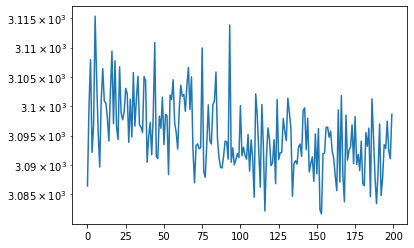

In [110]:
# Train the model:

class PrintDot(tf.keras.callbacks.Callback): # Copied from the manual; is called after each epoch
    def on_epoch_end(self, epoch, logs):
        if epoch % 500 == 0: print('')
        print('.', end='')


history = model.fit(d,epochs=200,verbose=0,callbacks=[PrintDot()],shuffle=True)

ax = plt.axes()
ax.plot(history.history['loss'])
ax.set_yscale('log')

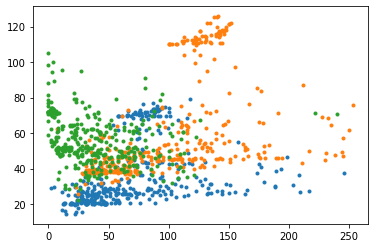

In [111]:
# Reconstruct one line of an image
def wrap(t):
    return t.reshape((1,) + t.shape).astype(float) # Some hacking to match the batch-defined dimensions of the model

one_guess = model.predict(wrap(x[0,:,:,:]),steps=1)
one_guess = np.squeeze(one_guess)

plt.plot(x[C.thick,0,:,:],one_guess,'.');

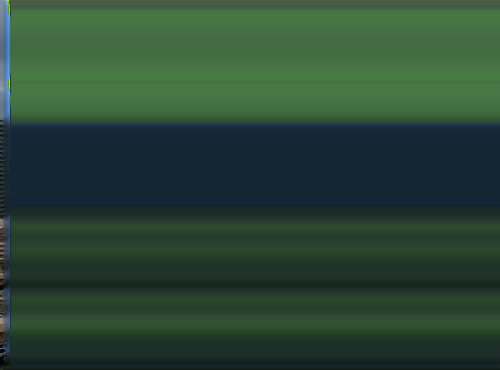

In [112]:
def generate_image(first_seed, model, control_variance=False):
    """Generate an image from a seed of 1-2 rows"""
    seed = first_seed.copy()
    sigma = np.std(seed.flatten())
    y = np.zeros((C.h , C.w , 3))
    for i in range(C.w):
        if i<C.thick:
            col = first_seed[i,:,:]
        else:
            col = model.predict(wrap(seed),steps=1) # Dim: (thick, 370, 3) before wrapping; (1, 2, 370, 3) after
            col = np.squeeze(col)
        if control_variance:
            bias = np.mean(col,axis=0)
            col = (col-bias)/np.std(col.flatten())*sigma + bias # Variance normalization for a column of pixels
        
        y[:,i,:] = col
        seed = np.concatenate((seed[:-1,:,:], np.expand_dims(col,0)), axis=0)

    img = Image.fromarray(np.uint8(y),"RGB") # Without this weird uint8 type-casting, doesn't work
    img = img.convert('RGB')
    return img
    
im2 = generate_image(np.squeeze(x[0,:,:,:]), model, control_variance=False)
display(im2)

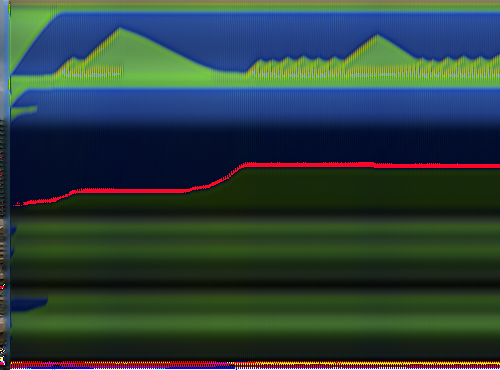

In [113]:
im2 = generate_image(np.squeeze(x[0,:,:,:]), model, control_variance=True)
display(im2)

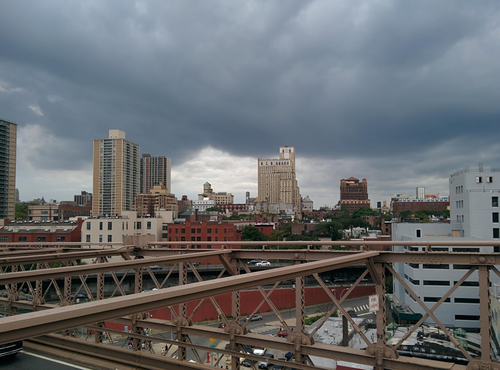

0


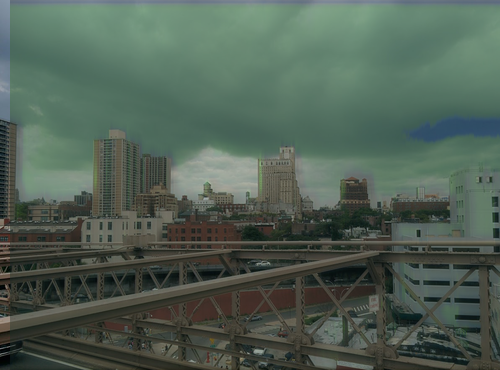

1
2
3


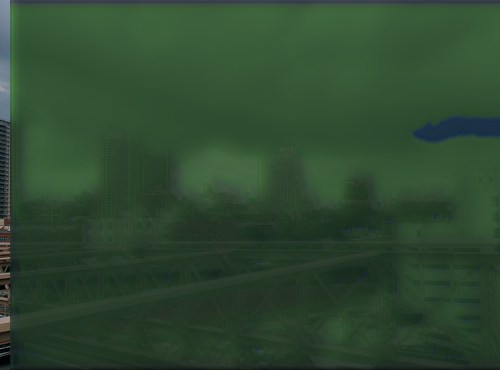

4
5
6


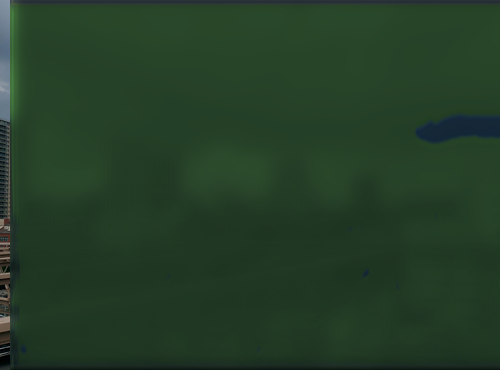

In [118]:
def transform_image(ground, model, mix=0.5):
    """Shape one image (argument) towards the other one using a model."""
    y = np.zeros((C.h , C.w , 3))
    for i in range(C.w):
        if i<C.thick:
            col = ground[:,i,:]
        else:
            seed = np.rollaxis(ground[:,range(i-C.thick,i),:],1,0)
            col = model.predict(wrap(seed),steps=1)
            col = np.squeeze(col)
        
        y[:,i,:] = col
        
    if mix<1:
        y = y*mix + ground*(1-mix)

    img = Image.fromarray(np.uint8(y),"RGB") # Without this weird uint8 type-casting, doesn't work
    img = img.convert('RGB')
    return img

im = load_image(1 , (500,600))
display(im)
for q in range(7):
    print(q)
    im = transform_image(im_to_numpy(im), model, mix=0.5)
    if q % 3 ==0:
        display(im)